# CLOSED LOOP SYSTEMS

This notebook is a companion to the slides for understanding closed loop systems.

# Preliminaries

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

# Helpers

In [3]:
def plotStep(tf, is_plot=True):
    """
    Plots a transfer function step response
    
    Parameters
    ----------
    tf: control.TransferFunction
    """
    result = control.forced_response(tf, T=TIMES, U=1)
    if is_plot:
        plt.plot(result.t, result.outputs)

# TESTS
Gs = control.TransferFunction([2], [1, 3])
plotStep(Gs, is_plot=False)
print("OK!")

OK!


# Antimony Model

$\$S_1 \xrightarrow{k_1 S_1} S_2$,
$S_2 \xrightarrow{k_2 S_3} S_3$,
$S_3 \xrightarrow{k_3 S_3} S_2$,
$S_2 \xrightarrow{k_2 S_3} \emptyset$,

In [4]:
# Constants
CONSTANT_DCT = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
s = sympy.Symbol("s")
REF = 10

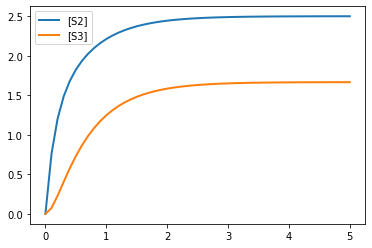

In [5]:
MODEL = """
$S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 0
k2 = 0
k3 = 0
k4 = 0
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR = te.loada(MODEL)
for k in CONSTANT_DCT.keys():
    RR[k] = CONSTANT_DCT[k]
RR.simulate()
RR.plot()


<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-Transfer-Function.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

We are going to control ``S3`` by changing ``S2``. That is, $U(s) = S_2  (s)$
and $Y(s) = S_3 (s)$.

# Simulating the Closed Loop System

In [6]:
ctlsb = ctl.ControlSBML(RR,  input_names=["S2"], output_names=["S3"])

In [7]:
sys = ctlsb.makeNonlinearIOSystem("sys")

In [8]:
ctlsb.makeStateSpace()

StateSpace(array([[-3.]]), array([[2.]]), array([[1.]]), array([[0.]]))

In [9]:
def controller_outfcn(_, __, u, param_dct):
    k = param_dct.get("k", 2)
    ref = param_dct.get("ref", REF)
    return k*([REF] - u[0])
#
controller = control.NonlinearIOSystem(
    None, controller_outfcn, inputs=['in'], outputs=['out'],
    name="controller")

In [10]:
# Create the closed loop system
closed_loop = control.interconnect(
  [sys, controller],       # systems
  connections=[
    ['sys.S2', 'controller.out'],
    ['controller.in',  'sys.S3'],
  ],
  inplist=["controller.in"],
  outlist=["sys.S2", "sys.S3"],
)

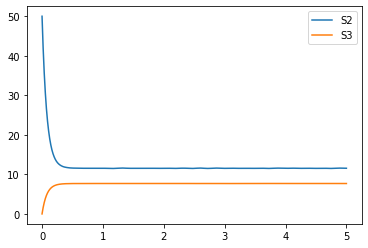

In [11]:
param_dct = {"k": 5, "ref": REF}
result = control.input_output_response(closed_loop, T=TIMES, params=param_dct)
plt.plot(TIMES, result.outputs[0], TIMES, result.outputs[1])
plt.legend(["S2", "S3"])

In [12]:
result.outputs[1][-2:]

array([7.68988725, 7.68994905])

In [13]:
type(control.feedback(controller, sys))

control.iosys.InterconnectedSystem

The output is biased! We wanted $S_3$ to be 10, but it's 7.6.

# Analyzing the Cause of Bias

Using direct calculation, I have calculated the transfer function $G(s) = \frac{k_2}{s + k_3}$.

In [14]:
numerator = CONSTANT_DCT["k2"]
denominator = [1, CONSTANT_DCT["k3"]]
tf = control.TransferFunction(numerator, denominator)
tf

TransferFunction(array([2]), array([1, 3]))

In [15]:
G = 2/(s + 3)
G

2/(s + 3)

In [16]:
C = sympy.symbols("k")

We calculate the transfer function for the closed loop system, $H(s) = \frac{Y(s)}{R(s)}$.

# Constructing Transfer Functions

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Transfer-Functions.png?raw=true"
     alt="Markdown Monster icon" width=300pt
     style="float: left; margin-right: 10px;" />

In the following, we use $G(s) = \frac{2}{s + 3}$ and $C(s) = k$ (proportional control).

In [17]:
Gs = control.TransferFunction([2], [1, 3])
Gs

TransferFunction(array([2]), array([1, 3]))

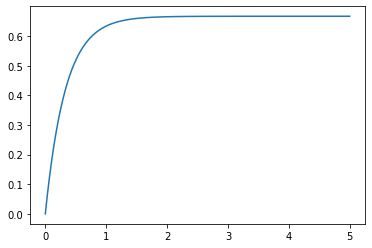

In [18]:
plotStep(Gs)

The original system, $G(s)$, settles around time 1.

In [19]:
k = 5
Cs = control.TransferFunction([k], [1])
Cs.dcgain()

5.0

For the filter, we use a low pass filter.

$F(s) = \frac{k_f}{s + k_f}$. Note that the DC Gain of $F(s)$ is 1.

In [20]:
kf = 5
Fs = control.TransferFunction([kf], [1, kf])
Fs.dcgain()

1.0

We use the above transfer functions to construct the various closed loop transfer functions.
Note that you can multiply and divide transfer function objects.

In [21]:
HRYs = control.minreal(Cs*Gs/(1 + Cs*Gs))
HRYs

1 states have been removed from the model


TransferFunction(array([10.]), array([ 1., 13.]))

In [22]:
HRYs.pole()

array([-13.])

In [23]:
HRYs.dcgain()

0.7692307692307693

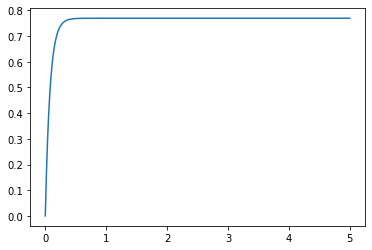

In [24]:
plotStep(HRYs)

The closed loop system settles around time 0.5.

Now we include the filter

In [25]:
HRYs = control.minreal(Cs*Gs/(1 + Cs*Gs*Fs))
HRYs

1 states have been removed from the model


TransferFunction(array([10., 50.]), array([ 1.,  8., 65.]))

In [26]:
HRYs.dcgain()

0.7692307692307698

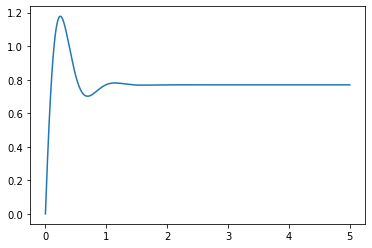

In [27]:
plotStep(HRYs)

In [28]:
HREs = control.minreal(1/(1 + Cs*Gs*Fs))
HREs

0 states have been removed from the model


TransferFunction(array([ 1.,  8., 15.]), array([ 1.,  8., 65.]))

We moved the pole of the original system from -3 to -13.